In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from functools import partial

from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
table = Table('cprof_mu_train_10000ev.h5')

ene_bins = table.normalize(0, table.binning[0])
cos_bins = table.normalize(1, np.linspace(min(table.binning[1]), max(table.binning[1]), 200))
trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), max(table.binning[2]), 200))

cos_trk_mesh = np.array([[x,y] for x in cos_bins for y in trk_bins])
linear_interpolator = interpolate.interp1d(table.binning[0], ene_bins, kind='linear')
grid_shape = (table.binning[1].shape[0]*table.binning[2].shape[0],3)

siren_light_profile, siren_params = load_siren_jax('siren_cprof_mu.pkl')

In [3]:
import numpy as np

true_energies = np.load('true_energies.npy')
true_integrals = np.load('true_integrals.npy')

energy_to_integral = dict(zip(true_energies, true_integrals))

In [4]:
energies = range(200,900,50)

In [5]:
from tqdm import tqdm
from tools.generate import new_differentiable_get_rays
from tools.simulation import create_siren_grid

key = random.PRNGKey(0)
table_data = create_siren_grid(table)
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])

Nphots = [50_000, 200_000, 1_000_000]

integral_results = []
for Nphot in Nphots:
    sum_phot_w = []
    # Using tqdm to create a progress bar
    for i, energy in tqdm(enumerate(energies), total=len(energies), desc="Processing energies"):
        ray_vectors, ray_origins, photon_weights = new_differentiable_get_rays(origin, direction, energy, Nphot, table_data, siren_params, key)
        sum_phot_w.append(np.sum(photon_weights))

    integral_results.append(sum_phot_w)

Processing energies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:24<00:00,  1.75s/it]


In [6]:
true_int = np.array([energy_to_integral[x] for x in energies])

[    850.01675354 -146722.00045114]


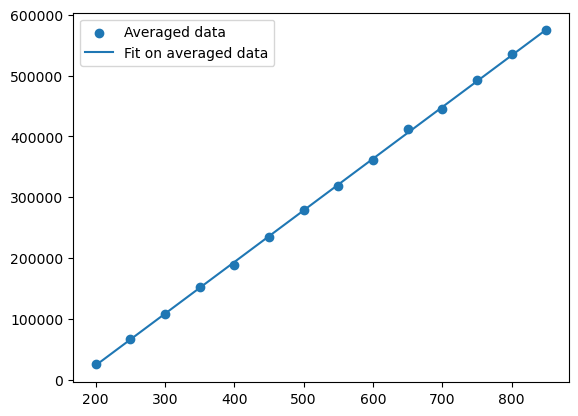

In [7]:
# First, create an array to store all y values
all_y_values = []

# Calculate y values for each N_photons case
for i in range(len(Nphots)):
    y = true_int/(np.array(integral_results[i])/Nphots[i])
    all_y_values.append(y)

# Convert to numpy array and calculate mean across all runs
all_y_values = np.array(all_y_values)
y_averaged = np.mean(all_y_values, axis=0)

# Perform single fit on the averaged y values
x = energies
coefficients = np.polyfit(x, y_averaged, 1)
fit_line = np.poly1d(coefficients)

# Plot the results
plt.scatter(x, y_averaged, label='Averaged data')
plt.plot(x, fit_line(x), label='Fit on averaged data')
plt.legend()
print(coefficients)

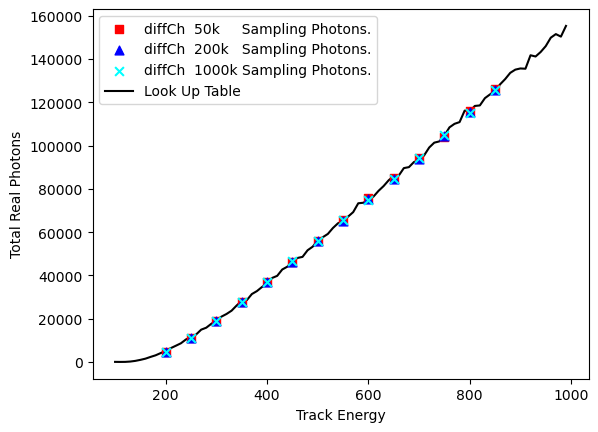

In [8]:
def format_label(nphot):
    num_str = str(int(nphot / 1000))  # Convert number to string
    spacing = (4- len(num_str))*2  # Calculate required padding
    return f"diffCh  {num_str}k{' ' * spacing} Sampling Photons."

# Plot
for idx in range(len(Nphots)):
    tot_real_photons_norm = [(x*852.97855369-148646.90865158)/Nphots[idx] for x in energies]
    Y = np.array(integral_results[idx])*tot_real_photons_norm

    plt.scatter(energies, Y, s=40, color=['r', 'b', 'cyan'][idx], marker=['s', '^', 'x'][idx], 
                label=format_label(Nphots[idx]))

plt.plot(true_energies, true_integrals, label='Look Up Table', color='k', zorder=-1)
plt.gca().set_xlabel('Track Energy')
plt.gca().set_ylabel('Total Real Photons')

plt.legend()

plt.show()